# Accuracy Validation

In this notebook, the main goal is to validate the accuracy of the models using 5-fold cross validation. This step is to prove if the model has a great accuracy on the training dataset. Besides that, cross validation can also help to check if the models overfit the training dataset.  

In [10]:
# import all of the packages that will be used

# basic packages for data processing
import pandas as pd
import numpy as np

# packege for calculation
import math

# packages for machine learning
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from skelm import ELMClassifier

# packages to interpret the training result
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

# package to benchmark the CPU running time
from time import process_time
from memory_profiler import memory_usage

# silent the warning from sklearn package
import warnings
warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
import random
random.seed(10)
np.random.seed(10)

In [11]:
# Loading the feature list
features = pd.read_csv('dataset/features_selected/CIC-IDS2018_RandomForestClassifier_20.csv').squeeze()
features = features[:11]

## Load the dataset

In this notebook, only the training dataset is used. 

In [12]:
columns = features.tolist() +  ['Label']

ids2018 = pd.read_csv('./dataset/dataset_cleaned/CSE-CIC-IDS2018_cleaned.csv', usecols=columns)
ids2018.shape

(515582, 12)

## Additional Processing

In [13]:
ids2018 = ids2018.sample(frac=0.3).reset_index(drop=True)

### Split the features and the labels 

In [14]:
ids2018_X = ids2018.drop('Label', axis=1).copy()
ids2018_y = ids2018['Label'].copy()

ids2018_train_X, ids2018_test_X, ids2018_train_y, ids2018_test_y = train_test_split(ids2018_X, ids2018_y, test_size=0.3)

### Data scaling

In [15]:
scalar = StandardScaler()
# only fit the training data
ids2018_X_scaled = scalar.fit_transform(ids2018_X)

## Build the ultimate models

In [18]:
# Custom wrapper for ELMClassifier to define the missing `pairwise` tag
class CustomELMClassifier(ELMClassifier):
    def _get_tags(self):
        tags = super()._get_tags()
        # Add the missing pairwise tag
        tags['pairwise'] = False
        return tags


In [19]:
models = {
    'Decision Tree': tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=1.4401469385343852e-05),
    'Random Forest': RandomForestClassifier(max_depth=20, min_samples_leaf=0.00001, min_samples_split=0.00001, n_estimators=350, n_jobs=-1,criterion='gini'),
    'Naive Bayes': GaussianNB(var_smoothing=1.0),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', alpha=0.0001, solver='adam', max_iter=1000),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(15, 15, 15), activation='tanh', alpha=1e-05, solver='adam', max_iter=1000),
    'Extreme Learning Machine': CustomELMClassifier(n_neurons=7000, ufunc='relu', alpha=1e-05, batch_size=1000)
}

In [20]:
accuracy_scores = {}
accuracy_scores_mean = {}
accuracy_scores_std = {}

cv = StratifiedKFold(n_splits=5, shuffle=True)

for model in models:
    clf = models[model]

    accuracy_scores[model] = cross_val_score(clf, 
                                            ids2018_X_scaled, 
                                            ids2018_y, 
                                            cv=cv, 
                                            scoring='accuracy',
                                            n_jobs=-1)
    accuracy_scores_mean[model] = np.mean(accuracy_scores[model])
    accuracy_scores_std[model] = np.std(accuracy_scores[model])

    print(f"{'-'*25} {model} {'-'*25}")
    print(f"Accuracy: {accuracy_scores[model]}")
    print(f"mean: {accuracy_scores_mean[model]:.4f}\t\tstd: {accuracy_scores_std[model]:.4f}")

------------------------- Decision Tree -------------------------
Accuracy: [0.96065945 0.96030386 0.95700663 0.95581057 0.95923711]
mean: 0.9586		std: 0.0019
------------------------- Random Forest -------------------------
Accuracy: [0.97297559 0.97249071 0.97287862 0.97294327 0.97407467]
mean: 0.9731		std: 0.0005
------------------------- Naive Bayes -------------------------
Accuracy: [0.65201228 0.65240019 0.65133344 0.65602069 0.65530952]
mean: 0.6534		std: 0.0019
------------------------- Artificial Neural Network -------------------------
Accuracy: [0.94397931 0.9437207  0.94362373 0.94504606 0.94388233]
mean: 0.9441		std: 0.0005
------------------------- Deep Neural Network -------------------------
Accuracy: [0.95445289 0.95532568 0.96764183 0.96938743 0.95345078]
mean: 0.9601		std: 0.0070
------------------------- Extreme Learning Machine -------------------------
Accuracy: [0.96725392 0.96728625 0.96877323 0.96796509 0.96670438]
mean: 0.9676		std: 0.0007


## Accuracy score of each model

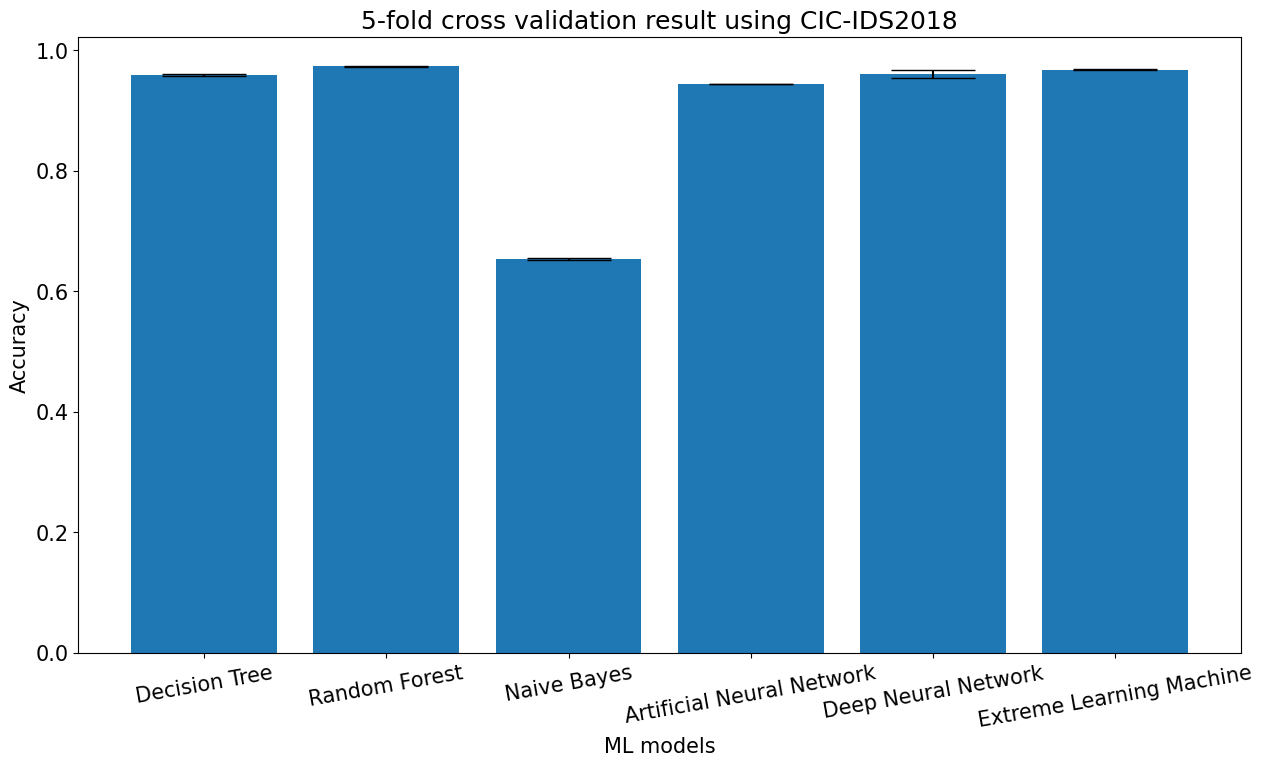

In [21]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize= (15, 8))

ax.bar(accuracy_scores_mean.keys(),
        accuracy_scores_mean.values(),
        yerr=accuracy_scores_std.values(),
        capsize=30)
ax.set_xlabel('ML models')
ax.set_ylabel('Accuracy')
ax.set_title('5-fold cross validation result using CIC-IDS2018')
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label

plt.show()